# Regression

Regression is the process of approximating noisy data with functions.  The same numerical methods can also be used to approximate a complicated function with a simpler function.  We'll begin by looking at some limited cases in terms of linear algebra.

## Polynomial regression

Long ago (in the Linear Algebra notebook), we solved an over-determined linear system to compute a polynomial approximation of a function.
Sometimes we make approximations because we are interested in the polynomial coefficients.
That is usually only for very low order (like linear or quadratic fits).
Inferring higher coefficients is ill-conditioned (as we saw with Vandermonde matrices) and probably not meaningful.
We now know that Chebyshev bases are good for representing high-degree polynomials, but if the points are arbitrarily spaced, how many do we need for the Chebyshev approximation to be well-conditioned?

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (
        np.cos(np.linspace(-np.pi, 0, n)))

def vander_chebyshev(x, n=None):
    if n is None:
        n = len(x)
    T = np.ones((len(x), n))
    if n > 1:
        T[:,1] = x
    for k in range(1,n-1):
        T[:,k+1] = 2 * x * T[:,k] - T[:,k-1]
    return T

def runge1(x):
    return 1 / (1 + 10*x**2)

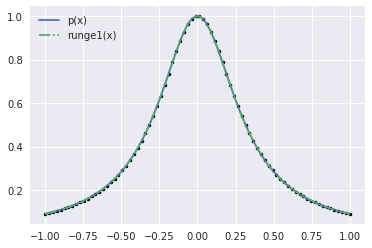

In [2]:
#This looks very much like interpolate and evaluate that we'e seen before.
#Diff is we get to choose our sizes here
def chebyshev_regress_eval(x, xx, n):
    V = vander_chebyshev(x, n)
    Q, R = np.linalg.qr(V) # solving using the QR factorization
    return vander_chebyshev(xx, n) @ np.linalg.solve(R, Q.T)

xx = np.linspace(-1, 1, 100) # outputs
x = np.linspace(-1, 1, 80) # inputs
#x = np.linspace(-1, 1, 40) #try this, will notice huge artifacts on sides, if you increase n, artifacts diminish
plt.plot(x, runge1(x), '.k')
plt.plot(xx, chebyshev_regress_eval(x, xx, 40) @ runge1(x), label='p(x)')
plt.plot(xx, runge1(xx), '-.', label='runge1(x)')
plt.legend(loc='upper left');

NOTES: If input `n` is equal to input `x`, we'd be doing interpolation. Here we want to allow `n < len(x)`

NOTES: Artifacts are bad. Notice the commented line in the code. Try it out.

NOTES: Degree of the polynomial is the `40` in line 12

* What is the degree $k$ of the polynomial that is used?
    - 40 from line 12
* What distribution of points is used for the data?
* Would this have artifacts if we used a degree $k$ polynomial to interpolate noise-free samples at $k+1$ points using the same distribution?
    - Yes. see commented line in code and try it out to see.

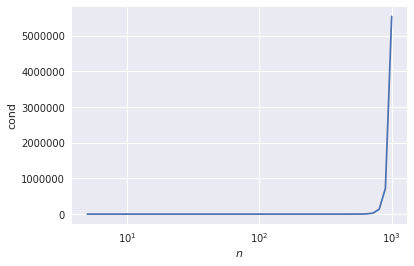

In [3]:
ns = np.geomspace(5, 1000, dtype=int)
# take data at n points
conds = [np.linalg.cond(vander_chebyshev(np.linspace(-1, 1, n),
                                         int(n/5)))
         for n in ns]

#conds = [np.linalg.cond(vander_chebyshev(np.linspace(-1, 1, n),int(n**.8)))for n in ns] #Try this to take small pow of n

plt.semilogx(ns, conds) # plot its condition number
plt.xlabel('$n$')
plt.ylabel('cond');

NOTES: Ask yourself what happens when we reduce the power? Try line 7 to see.
<br>=> It gets better. The growth of the condition number is manageable. At least it is for pow .5 instead of .8

NOTES: We see that condition # does eventually blow up

* If we have $n$ data points, can we use a polynomial of degree $k = \lfloor n/5 \rfloor$?
* What about $k = n^{3/4}$?
* What expression $k = ?(n)$ appears to be sufficient?

## Noisy data

Regression really comes into its own when the data is noisy.

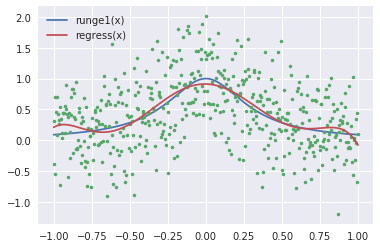

In [4]:
def runge1_noisy(x, sigma):
    return runge1(x) + np.random.randn(*x.shape)*sigma
# np.random.randn gies normalli dist rand variables
# parameterize by sigma whcih determines how broad this func is.

x = np.linspace(-1, 1, 500)
y = runge1_noisy(x, 0.5)
plt.plot(x, runge1(x), label='runge1(x)')
plt.plot(x, y, '.')
plt.plot(x, chebyshev_regress_eval(x, x, 7) @ y, label='regress(x)') #plot degree 6 polynomial approximation
plt.legend(loc='upper left');

NOTES: Notice that we tend to miss the blue curve in the middle and at the end points.

PROMPT: How can we more accurately get the model? i.e. get a graph that fits the blue line better

### Probability distributions

In order to interpret real data, we need a model for the noise.  We have chosen the most common and computationally convenient choice when creating the synthetic data above.
The function `randn` draws samples from the "standard normal" or Gaussian distribution.

$$ p(t) = \frac{1}{\sqrt{2\pi}} e^{-t^2/2} . $$

NOTES: This is called the Gaussian/Normal distribution

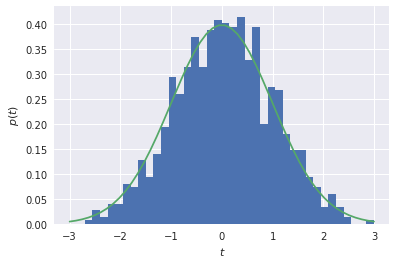

In [5]:
def stdnormal(t):
    # prob of each event for a value t
    return np.exp(-t**2/2) / np.sqrt(2*np.pi)

n = 1000
w = np.random.randn(n) #draw n samples
plt.hist(w, bins=40, range=(-3,3), density=True) #plot histogram
t = np.linspace(-3, 3)
plt.plot(t, stdnormal(t)) #take points t and plot the stdnormal dist
plt.xlabel('$t$')
plt.ylabel('$p(t)$');

### Regression on noisy data

We can just go run our regression algorithm on the noisy data.
<br>=> We can run regression on noisy data

In [6]:
x = np.linspace(-1, 1, 500)
y = runge1_noisy(x, sigma=0.1) 

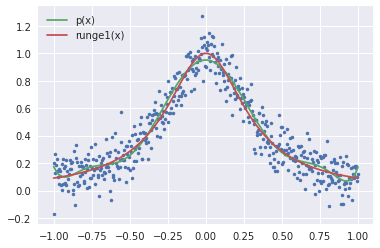

In [7]:
plt.plot(x, y, '.')
plt.plot(xx, chebyshev_regress_eval(x, xx, 9) @ y, label='p(x)') # degree 8 polynomial
plt.plot(xx, runge1(xx), label='runge1(x)')
plt.legend(loc='upper left');

NOTES: Smaller sigma gives us more accurate results.

## What problem are we solving?

### Why do we call it a linear model?

We are currently working with algorithms that express the regression as a linear function of the model parameters.  That is, we search for coefficients $c = [c_0, c_1, \dotsc]^T$ such that

$$ V(x) c \approx y $$

NOTES: It's a linear model if this predictor is linear in the coefficient $c$
<br>NOTES: Given data $y$, we compute the coefficients $c$, and use that to make preditions.

where the left hand side is linear in $c$.  In different notation, we are searching for a predictive model

$$ f(x_i, c) \approx y_i \text{ for all $(x_i, y_i)$} $$

NOTES: We want in some sense for $f$ to be able to approx data. $f$ is the **predictor**

that is linear in $c$.

### Assumptions

1. The independent variables $x$ are error-free
1. The prediction (or "response") $f(x,c)$ is linear in $c$
1. The noise in the measurements $y$ is independent (uncorrelated) // assume that the noise has a mean of zero. (rarely true in practice)
1. The noise in the measurements $y$ has constant variance

There are reasons why all of these assumptions may be undesirable in practice, thus leading to more complicated methods.

### Loss functions

The error in a single prediction $f(x_i,c)$ of an observation $(x_i, y_i)$ is often measured as
$$ \frac 1 2 \big( f(x_i, c) - y_i \big)^2, $$

NOTES: We've been trying to minimize this error.

which turns out to have a statistical interpretation when the noise is normally distributed.
It is natural to define the error over the entire data set as
\begin{align} L(c; x, y) &= \sum_i \frac 1 2 \big( f(x_i, c) - y_i \big)^2 \\
&= \frac 1 2 \lVert f(x, c) - y \rVert^2
\end{align}

NOTES: x and y are vectors that are the inputs and outputs. Here we're taking the sum of the errors.
<br>NOTES: y is the vector of all observations, the 2nd eq is the norm squared of the residual

where I've used the notation $f(x,c)$ to mean the vector resulting from gathering all of the outputs $f(x_i, c)$.
The function $L$ is called the "loss function" and is the key to relaxing the above assumptions.

#### Optimization
Given data $(x,y)$ and loss function $L(c; x,y)$, we wish to find the coefficients $c$ that minimize the loss, thus yielding the "best predictor" (in a sense that can be made statistically precise).  I.e.,
$$ \bar c = \arg\min_c L(c; x,y) . $$

NOTES: We would like to find $c$ that minimizes the loss over the data we have. We do it via method below:

It is usually desirable to design models such that the loss function is differentiable with respect to the coefficients $c$, because this allows the use of more efficient optimization methods.  For our chosen model,
\begin{align} \nabla_c L(c; x,y) = \frac{\partial L(c; x,y)}{\partial c} &= \sum_i \big( f(x_i, c) - y_i \big) \frac{\partial f(x_i, c)}{\partial c} \\
&= \sum_i \big( f(x_i, c) - y_i \big) V(x_i)
\end{align}

NOTES: The derivative of a sum of things is the sum of the derivatives of those things.
<br>NOTES: this looks a lot like the vandormonde function.
<br>NOTES: 

where $V(x_i)$ is the $i$th row of $V(x)$.
A more linear algebraic way to write the same expression is
\begin{align} \nabla_c L(c; x,y) &= \big( f(x,c) - y \big)^T V(x) \\
&= \big(V(x) c - y \big)^T V(x) \\
&= V(x)^T \big( V(x) c - y \big)
\end{align}
A necessary condition for the loss function to be minimized is that $\nabla_c L(c; x,y) = 0$.

NOTES: V(x) is the deriative matrix, here it's the Vandermonde matrix<br>
NOTES: Derivative of the loss func respect to $c$ must be zero.

* Is the condition sufficient for general $f(x, c)$? It's necessary but not sufficient
* Is the condition sufficient for the linear model $V(x) c$?
* Have we seen this sort of equation before?
    - Closely related to rootfinding

##### Uniqueness
We can read the expression $ V(x)^T \big( V(x) c - y \big) = 0$ as saying that the residual $V(x) c - y$ is orthogonal to the range of $V(x)$.  Suppose $c$ satisfies this equation and $c' \ne c$ is some other value of the coefficients.  Then
\begin{align}
V(x)^T \big( V(x) c' - y \big) &= V(x)^T V(x) c' - V(x)^T y \\
&= V(x)^T V(x) c' - V(x)^T V(x) c \\
&= V(x)^T V(x) (c' - c) \ne 0
\end{align}
whenever $V(x)^T V(x)$ is nonsingular, which happens any time $V(x)$ has full column rank.

NOTES: $V(x)^T V(x)$ is nonsingular, so $V(x)^T V(x)(c'-c)$ can't equal zero, and thus we have a uniqure solution.

##### Gradient descent
Instead of solving the least squares problem using linear algebra (QR factorization), we could solve it using gradient descent.  That is, on each iteration, we'll take a step in the direction of the negative gradient.

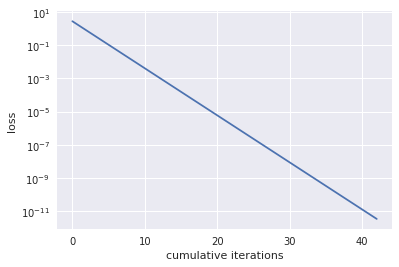

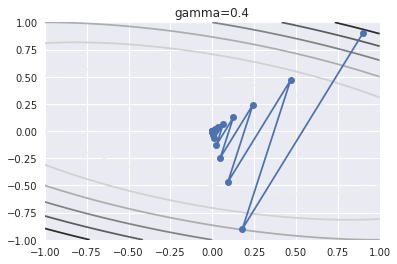

In [15]:
def grad_descent(loss, grad, c0, gamma=1e-3, tol=1e-5):
    """Minimize loss(c) via gradient descent with initial guess c0
    using learning rate gamma.  Declares convergence when gradient
    is less than tol or after 500 steps.
    """
    c = c0.copy()
    chist = [c.copy()]
    lhist = [loss(c)]
    for it in range(500):
        g = grad(c) # compute gradient
        c -= gamma * g #takes a step in the negative gradient
        chist.append(c.copy())
        lhist.append(loss(c))
        if np.linalg.norm(g) < tol:
            break
    return c, np.array(chist), np.array(lhist)

class quadratic_loss:
    """Test problem to give example of gradient descent."""
    def __init__(self):
        self.A = np.array([[1, 1], [1, 4]])
    def loss(self, c):
        return .5 * c @ self.A @ c
    def grad(self, c):
        return self.A @ c

def test(gamma):
    q = quadratic_loss()
    c, chist, lhist = grad_descent(q.loss, q.grad, .9*np.ones(2), gamma=gamma)
    plt.semilogy(lhist)
    plt.ylabel('loss')
    plt.xlabel('cumulative iterations')

    plt.figure()
    l = np.linspace(-1, 1)
    x, y = np.meshgrid(l, l)
    z = [q.loss(np.array([x[i,j], y[i,j]])) for i in range(50) for j in range(50)]
    plt.contour(x, y, np.reshape(z, x.shape))
    plt.plot(chist[:,0], chist[:,1], 'o-')
    plt.title('gamma={}'.format(gamma))
    
test(.4)

NOTES: If gamma is small enough, we converge better. If gamma is bigger, we overshoot more. Try a smaller gamma to see the diff <br>

NOTES: If this was more stretched left and right, we'd converge slower.

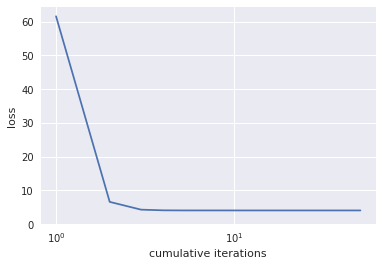

In [19]:
class chebyshev_regress:
    def __init__(self, x, y, n):
        self.V = vander_chebyshev(x, n)
        self.y = y
        self.n = n
        
    def init(self):
        return np.zeros(self.n)

    def loss(self, c):
        r = self.V @ c - y
        return 0.5 * (r @ r)
    
    def grad(self, c):
        r = self.V @ c - y
        return self.V.T @ r
    
reg = chebyshev_regress(x, y, 6)
c, _, lhist = grad_descent(reg.loss, reg.grad, reg.init(), gamma=2e-3)
plt.semilogx(np.arange(1, 1+len(lhist)), lhist)
plt.ylabel('loss')
plt.xlabel('cumulative iterations')
plt.ylim(bottom=0);

* How does changing the "learning rate" `gamma` affect convergence?
* How does changing the number of basis functions affect convergence rate?

#### Did we find the same solution?
We intend to solve the same problem as we previously solved using QR, so we hope to find the same solution.

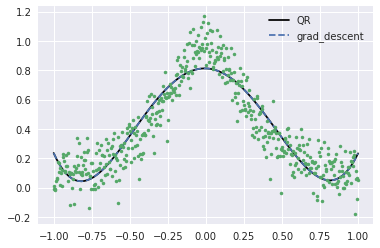

In [20]:
plt.plot(xx, chebyshev_regress_eval(x, xx, 6) @ y, '-k', label='QR')
plt.plot(xx, vander_chebyshev(xx, 6) @ c, '--', label='grad_descent')
plt.plot(x, y, '.')
plt.legend();

NOTES: We see that they're converging to the same solution. that's comforting.

#### Observations

* This algorithm is kind of finnicky:
 * It takes many iterations to converge
 * The "learning rate" needs to be empirically tuned
 * When not tuned well, the algorithm can diverge
* It could be made more robust using a line search
* The $QR$ algorithm is a more efficient and robust way to solve these problems

## Nonlinear regression

Instead of the linear model
$$ f(x,c) = V(x) c = c_0 + c_1 \underbrace{x}_{T_1(x)} + c_2 T_2(x) + \dotsb $$
let's consider a rational model with only three parameters
$$ f(x,c) = \frac{1}{c_0 + c_1 x + c_2 x^2} = (c_0 + c_1 x + c_2 x^2)^{-1} . $$
We'll use the same loss function
$$ L(c; x,y) = \frac 1 2 \lVert f(x,c) - y \rVert^2 . $$

We will also need the gradient
$$ \nabla_c L(c; x,y) = \big( f(x,c) - y \big)^T \nabla_c f(x,c) $$
where
\begin{align}
\frac{\partial f(x,c)}{\partial c_0} &= - f(x,c)^2 \\
\frac{\partial f(x,c)}{\partial c_1} &= - f(x,c)^2 x \\
\frac{\partial f(x,c)}{\partial c_2} &= - f(x,c)^2 x^2 .
\end{align}

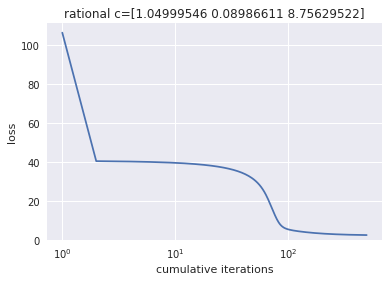

In [21]:
class rational_regress:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.n = 3
        
    def init(self):
        return np.ones(self.n)
    
    def f(self, c):
        x = self.x
        return 1 / (c[0] + c[1]*x + c[2]*x**2)
        
    def df(self, c): # derivative of f
        x = self.x
        f2 = self.f(c)**2
        return np.array([-f2, -f2*x, -f2*x**2]).T

    def loss(self, c):
        r = self.f(c) - self.y
        return 0.5 * (r @ r)
    
    def grad(self, c):
        r = self.f(c) - self.y
        return r @ self.df(c)

reg = rational_regress(x, y)
c, _, lhist = grad_descent(reg.loss, reg.grad, reg.init(), gamma=2e-2)
plt.semilogx(np.arange(1, 1+len(lhist)), lhist)
plt.ylabel('loss')
plt.xlabel('cumulative iterations')
plt.ylim(bottom=0)
plt.title('rational c={}'.format(c));

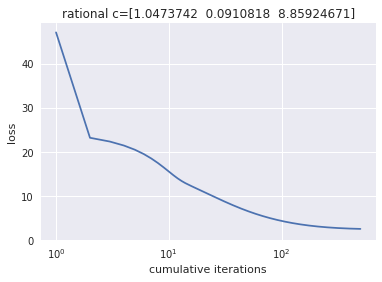

In [23]:
x = np.linspace(-1, 1, 500)
y = runge1_noisy(x, sigma=0.1)

c0 = np.array([1, 0, 1.])
c, _, lhist = grad_descent(reg.loss, reg.grad, c0, gamma=2e-2)
plt.semilogx(np.arange(1, 1+len(lhist)), lhist)
plt.ylabel('loss')
plt.xlabel('cumulative iterations')
plt.ylim(bottom=0)
plt.title('rational c={}'.format(c));

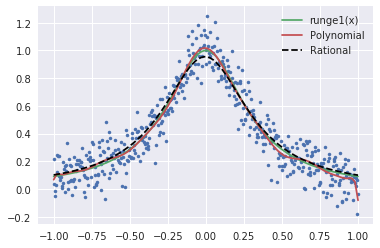

In [26]:
plt.plot(x, y, '.')
plt.plot(xx, runge1(xx), label='runge1(x)')
plt.plot(xx, chebyshev_regress_eval(x, xx, 20) @ y, label='Polynomial')
plt.plot(xx, 1/(c[0] + c[1]*xx + c[2]*xx**2), '--k', label='Rational')
plt.legend();

NOTES: Rational(black) seems the tmost appropriate <br>
NOTES: When we have noisy data, the ends get worse(for Polnynomial)

#### Observations

* There can be local minima or points that look an awful lot like local minima.
* Convergence is sensitive to learning rate.
* It takes a lot of iterations to converge.
* A well-parametrized model (such as the rational model above) can accurately reconstruct the mean even with very noisy data.

### Outlook

* The optimization problem can be solved using a Newton method.  It can be onerous to implement the needed derivatives.
* The [Gauss-Newton method](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm) (see homework) is often more practical than Newton while being faster than gradient descent, though it lacks robustness.
* The [Levenberg-Marquardt method](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) provides a sort of middle-ground between Gauss-Newton and gradient descent.
* Many globalization techniques are used for models that possess many local minima.
* One pervasive approach is stochastic gradient descent, where small batches (e.g., 1 or 10 or 20) are selected randomly from the corpus of observations (500 in our current example), and a step of gradient descent is applied to that reduced set of observations.  This helps to escape saddle points and weak local minima.
* Among expressive models $f(x,c)$, some may converge much more easily than others.  Having a good optimization algorithm is essential for nonlinear regression with complicated models, especially those with many parameters $c$.
* Classification is a very similar problem to regression, but the observations $y$ are discrete, thus

 * models $f(x,c)$ must have discrete output
 * the least squares loss function is not appropriate.